In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import torch

sys.path.append('..')
from src.utils import *
from src.configs import *

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
rcParams.update(fig_params)

import warnings

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

## Set device

In [2]:
DEVICE = 'cuda:3' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEVICE)

Using device: cuda:3


## Load experiments file

In [3]:
FILENAME = 'Experiments_MASSIVE.xlsx'

In [4]:
exp_df = pd.read_excel(os.path.join('..', 'experiments', FILENAME), dtype=FORMAT)
exp_df.head()

,exp_id,seed,torch_dtype,samples_number,features_number,snr_db,informative_frac,folds_number,initialization,epochs_number,learning_rate
0,MASSIVE000,8925,64,1000,100,20,0.5,5,1.0,300,350.0
1,MASSIVE001,65459,64,1000,100,20,0.5,5,1.0,300,350.0
2,MASSIVE002,30300,64,1000,100,20,0.5,5,1.0,300,350.0
3,MASSIVE003,38747,64,1000,100,20,0.5,5,1.0,300,350.0
4,MASSIVE004,26932,64,1000,100,20,0.5,5,1.0,300,350.0


## Run experiments

In [5]:
exp_df = exp_df.iloc[[100]].copy()
exp_df

,exp_id,seed,torch_dtype,samples_number,features_number,snr_db,informative_frac,folds_number,initialization,epochs_number,learning_rate
100,MASSIVE100,47464,64,1000,1100,20,0.5,5,1.0,300,350.0


In [6]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    os.environ["PYTHONWARNINGS"] = 'ignore'

for i, exp in exp_df.iterrows():
    EXP_ID = exp.exp_id
    SEED = exp.seed
    if exp.torch_dtype == 64:
        DTYPE = torch.float64
    elif exp.torch_dtype == 32:
        DTYPE = torch.float32
    N = exp.samples_number
    D = exp.features_number
    SNR_DB = exp.snr_db
    INFORMATIVE_FRAC = exp.informative_frac
    NUM_FOLDS = exp.folds_number
    INITIALIZATION = exp.initialization
    EPOCHS = exp.epochs_number
    LEARNING_RATE = exp.learning_rate

    exp.epochs_number = 10
    
    ### Create output folders
    os.makedirs(os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'data'), exist_ok=True)
    data_folder = os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'data')
    os.makedirs(os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'images'), exist_ok=True)
    images_folder = os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'images')
    
    ### Data generation
    train, test, features, target, theta_true = generate_synthetic_dataset(n_samples_train=N, n_samples_test=100000, n_features=D, n_informative=int(D*INFORMATIVE_FRAC),
                                                                           snr_db=SNR_DB, random_state=SEED)
    check_snr(train, test, features, target, theta_true, snr_db=SNR_DB)
    
    ### Cross-validation strategy
    folds = create_folds(train, features, target, num_folds=NUM_FOLDS, shuffle=True, seed=SEED)
    
    ### MultiRidge optimization
    initialization = np.ones(D)*exp.initialization
    history_df, history_coef, debug1 = optimize_MultiRidge(train, test, features, target, theta_true, folds, metrics={'r2': r2_score, 'mse': mean_squared_error},
                                                   exp_params=exp, device=DEVICE, normalize=True, initialization=initialization,
                                                   lr_scheduler=None, noise_rate=0.0)
    results_dict = {'exp_id': EXP_ID, 'history_df': history_df, 'history_coef': history_coef}
    with open(os.path.join(data_folder, f'{EXP_ID}.pickle'), 'wb') as handle:
        pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    history_df[['mean_train_r2', 'mean_valid_r2', 'test_r2_refit', 'train_r2_refit']].plot()
    plt.ylim(0.0, 1.0)
    pathfile_mr = os.path.join(images_folder, f'{EXP_ID}')
    plt.savefig(pathfile_mr, dpi = 200)
    plt.close()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train R2: 0.852, Valid R2: 0.472, Test R2: 0.532
Epoch 2: Train R2: 0.934, Valid R2: 0.733, Test R2: 0.651
Epoch 3: Train R2: 0.959, Valid R2: 0.795, Test R2: 0.718
Epoch 4: Train R2: 0.971, Valid R2: 0.848, Test R2: 0.767
Epoch 5: Train R2: 0.976, Valid R2: 0.864, Test R2: 0.798
Epoch 6: Train R2: 0.980, Valid R2: 0.885, Test R2: 0.829
Epoch 7: Train R2: 0.982, Valid R2: 0.882, Test R2: 0.855
Epoch 8: Train R2: 0.985, Valid R2: 0.910, Test R2: 0.873
Epoch 9: Train R2: 0.985, Valid R2: 0.900, Test R2: 0.874
Epoch 10: Train R2: 0.988, Valid R2: 0.919, Test R2: 0.886


In [8]:
class LinearLR():
    def __init__(self, initial_lr, decay):
        self.learning_rate = initial_lr
        self.decay = decay
        
    def update_lr(self, epoch):
        self.learning_rate *= self.decay


from sklearn.base import BaseEstimator, RegressorMixin

class MultiRidge(RegressorMixin, BaseEstimator):
    def __init__(self, lambda_vector=None, folds=5, shuffle=True, random_state=None, normalize=True, epochs=100, learning_rate=100, scoring='neg_mean_squared_error', verbose=0, save_history=True,
                 device='cpu', dtype=torch.float32):
        self.folds = folds
        self.shuffle = shuffle
        if self.shuffle is True:
            if not isinstance(random_state, int):
                self.random_state = 0
            else:
                self.random_state = random_state
        self.normalize = normalize
        self.epochs = epochs
        self.learning_rate = learning_rate
        if isinstance(scoring, str):
            from sklearn.metrics import get_scorer
            self.scoring = {scoring: get_scorer(scoring)._score_func}
        else:
            self.scoring = scoring
        self.verbose = verbose
        self.save_history = save_history
        if self.save_history is True:
            columns = [f'fold{fold+1}_{split}_{metric}' for fold in range(self.folds) for split in ['train', 'valid'] for metric in self.scoring.keys()] + \
                      [f'{stat}_{split}_{metric}' for stat in ['mean', 'std'] for split in ['train', 'valid'] for metric in self.scoring.keys()] + \
                      list(chain.from_iterable((f'test_{metric}_ensemble', f'test_{metric}_refit', f'train_{metric}_refit') for metric in self.scoring.keys()))
            self.history_df = pd.DataFrame(data=0.0, columns=columns, index=range(self.epochs))
        self.device = device
        self.dtype = dtype
        if lambda_vector is not None:
            self.lambda_vector = torch.tensor(lambda_vector, device=self.device, dtype=self.dtype)
        else:
            self.lambda_vector = None

        self.coef_ = None
            

    def fit(self, X, y, eval_set=None,  **kwargs):

        debug = {}
        
        if y is None:
            raise ValueError('requires y to be passed, but the target y is None')

        X_train, Y_train = check_X_y(X, y)
        Y_train = Y_train[:, np.newaxis]
        X_train_copy, Y_train_copy = X_train, Y_train, # np.copy(X_train), np.copy(Y_train)
        self.n_samples_in_  = X_train.shape[0]
        self.n_features_in_ = X_train.shape[1]

        if eval_set is not None:
            X_test, Y_test = check_X_y(eval_set[0], eval_set[1])
            Y_test = Y_test[:, np.newaxis]
            X_test_copy, Y_test_copy = X_test, Y_test # np.copy(X_test), np.copy(Y_test)

        if self.normalize is True:
            scaler_x, scaler_y = StandardScaler(), StandardScaler()
            X_train, Y_train = scaler_x.fit_transform(X_train), scaler_y.fit_transform(Y_train)
            if eval_set is not None:
                X_test, Y_test = scaler_x.transform(X_test), scaler_y.transform(Y_test)

        X_train, Y_train = torch.tensor(X_train, device=self.device, dtype=self.dtype), torch.tensor(Y_train, device=self.device, dtype=self.dtype)
        if eval_set is not None:
            X_test, Y_test = torch.tensor(X_test, device=self.device, dtype=self.dtype), torch.tensor(Y_test, device=self.device, dtype=self.dtype)
        
        Id = torch.eye(self.n_features_in_, device=self.device, dtype=self.dtype)
        ones = torch.ones(self.n_features_in_, 1, device=self.device, dtype=self.dtype)
        if self.lambda_vector is None:
            self.lambda_vector = torch.ones(self.n_features_in_, device=self.device, dtype=self.dtype)

        for k in tqdm(range(self.epochs), total=self.epochs):
            grad_E_cv = 0.0
            if eval_set is not None:
                Y_test_hat_ensemble = torch.zeros(X_test.shape[0], 1, device=self.device, dtype=self.dtype)
            
            kf = KFold(n_splits=self.folds, shuffle=self.shuffle, random_state=self.random_state*(k+1))
    
            for n_fold, (train_fold_idx, valid_fold_idx) in enumerate(kf.split(X_train_copy, Y_train_copy)):

                X_train_fold, Y_train_fold = X_train_copy[train_fold_idx], Y_train_copy[train_fold_idx]
                X_valid_fold, Y_valid_fold = X_train_copy[valid_fold_idx], Y_train_copy[valid_fold_idx]

                debug[k] = {}
                debug[k]['X_train_fold'] = X_train_fold
                debug[k]['Y_train_fold'] = Y_train_fold
                debug[k]['X_valid_fold'] = X_valid_fold
                debug[k]['Y_valid_fold'] = Y_valid_fold

                if self.normalize is True:
                    scaler_fold_x, scaler_fold_y = StandardScaler(), StandardScaler()
                    X_train_fold, Y_train_fold  = scaler_fold_x.fit_transform(X_train_fold), scaler_fold_y.fit_transform(Y_train_fold)
                    X_valid_fold, Y_valid_fold  = scaler_fold_x.transform(X_valid_fold), scaler_fold_y.transform(Y_valid_fold)

                debug[k]['scaler_fold_x'] = scaler_fold_x
                debug[k]['scaler_fold_y'] = scaler_fold_y
                
                X_train_fold, Y_train_fold = torch.tensor(X_train_fold, device=self.device, dtype=self.dtype), torch.tensor(Y_train_fold, device=self.device, dtype=self.dtype)
                X_valid_fold, Y_valid_fold = torch.tensor(X_valid_fold, device=self.device, dtype=self.dtype), torch.tensor(Y_valid_fold, device=self.device, dtype=self.dtype)
                N_train_fold, N_valid_fold = X_train_fold.shape[0], X_valid_fold.shape[0]
                
                Λ = torch.diag(self.lambda_vector)
                theta_fold_hat = torch.linalg.lstsq(X_train_fold.T @ X_train_fold + N_train_fold * Λ@Λ, X_train_fold.T @ Y_train_fold)[0]

                Y_train_fold_hat = X_train_fold @ theta_fold_hat
                Y_valid_fold_hat = X_valid_fold @ theta_fold_hat
                if eval_set is not None:
                    Y_test_hat_ensemble += X_test @ theta_fold_hat
                
                ## gradient computation
                R_fold = (Y_valid_fold_hat - Y_valid_fold)
                B_fold = torch.linalg.lstsq((X_train_fold.T @ X_train_fold + N_train_fold * Λ@Λ).T, X_valid_fold.T @ R_fold @ theta_fold_hat.T)[0]
                grad_E_fold = -(N_train_fold/N_valid_fold) * torch.diagonal(Λ@B_fold + B_fold@Λ)
                grad_E_cv += grad_E_fold/self.folds

                ## save fold metrics
                if self.save_history is True:
                    for metric, metric_func in self.scoring.items():
                        self.history_df.loc[k, f'fold{n_fold+1}_train_{metric}'] = metric_func(Y_train_fold.cpu().numpy(), Y_train_fold_hat.cpu().numpy())
                        self.history_df.loc[k, f'fold{n_fold+1}_valid_{metric}'] = metric_func(Y_valid_fold.cpu().numpy(), Y_valid_fold_hat.cpu().numpy())

            ## save aggregated statistics
            if self.save_history is True:
                for metric, metric_func in self.scoring.items():
                    self.history_df.loc[k, f'mean_train_{metric}'] = self.history_df.loc[k, [f'fold{fold+1}_train_{metric}' for fold in range(self.folds)]].mean()
                    self.history_df.loc[k, f'std_train_{metric}']  = self.history_df.loc[k, [f'fold{fold+1}_train_{metric}' for fold in range(self.folds)]].std(ddof=0)
                    self.history_df.loc[k, f'mean_valid_{metric}'] = self.history_df.loc[k, [f'fold{fold+1}_valid_{metric}' for fold in range(self.folds)]].mean()
                    self.history_df.loc[k, f'std_valid_{metric}']  = self.history_df.loc[k, [f'fold{fold+1}_valid_{metric}' for fold in range(self.folds)]].std(ddof=0)
                    if eval_set is not None:
                        self.history_df.loc[k, f'test_{metric}_ensemble'] = metric_func(Y_test.cpu().numpy(), Y_test_hat_ensemble.cpu().numpy())

            ## refit an all train and compute test score
            theta_hat_refit = torch.linalg.lstsq(X_train.T @ X_train + self.n_samples_in_ * Λ@Λ, X_train.T @ Y_train)[0]
            Y_train_hat_refit = X_train @ theta_hat_refit
            if eval_set is not None:
                Y_test_hat_refit = X_test @ theta_hat_refit

            if self.save_history is True:
                for metric, metric_func in self.scoring.items():
                    self.history_df.loc[k, f'train_{metric}_refit'] = metric_func(Y_train.cpu().numpy(), Y_train_hat_refit.cpu().numpy())
                    if eval_set is not None:
                        self.history_df.loc[k, f'test_{metric}_refit'] = metric_func(Y_test.cpu().numpy(), Y_test_hat_refit.cpu().numpy())
            if self.normalize is True:
                σy = np.sqrt(scaler_x.var_)
                σx = np.sqrt(scaler_y.var_)
                scale_factor = σy / σx
                self.coef_ = scale_factor * theta_hat_refit.cpu().numpy().squeeze()
            else:
                self.coef_ = theta_hat_refit.cpu().numpy().squeeze()

            ## logging
            if (self.verbose > 0) and (self.save_history is True):
                if k%self.verbose == 0:
                    text = "Epoch {}: ".format(k + 1)
                    for metric, _ in self.scoring.items():
                        text += "Train {}: {:.3f}, ".format(metric, self.history_df.loc[k, f'mean_train_{metric}'])
                        text += "Valid {}: {:.3f}, ".format(metric, self.history_df.loc[k, f'mean_valid_{metric}'])
                        if eval_set is not None:
                            text += "Test {}: {:.3f}, ".format(metric, self.history_df.loc[k, f'test_{metric}_refit'])
                    print(text[:-2])

            if isinstance(self.learning_rate, float):
                self.lambda_vector = self.lambda_vector - self.learning_rate * grad_E_cv
            else:
                self.lambda_vector = self.lambda_vector - self.learning_rate.learning_rate * grad_E_cv
                self.learning_rate.update_lr(k)
        
        self.is_fitted_ = True

        return self, debug

    def predict(self, X):
        check_is_fitted(self, 'is_fitted_')
        X = check_array(X)
        return None

    def _more_tags(self):
        return {
            'poor_score': True
        }

In [10]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    os.environ["PYTHONWARNINGS"] = 'ignore'

for i, exp in exp_df.iterrows():
    EXP_ID = exp.exp_id
    SEED = exp.seed
    if exp.torch_dtype == 64:
        DTYPE = torch.float64
    elif exp.torch_dtype == 32:
        DTYPE = torch.float32
    N = exp.samples_number
    D = exp.features_number
    SNR_DB = exp.snr_db
    INFORMATIVE_FRAC = exp.informative_frac
    NUM_FOLDS = exp.folds_number
    INITIALIZATION = exp.initialization
    EPOCHS = exp.epochs_number
    LEARNING_RATE = exp.learning_rate
    
    ### Create output folders
    os.makedirs(os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'data'), exist_ok=True)
    data_folder = os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'data')
    os.makedirs(os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'images'), exist_ok=True)
    images_folder = os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'images')
    
    ### Data generation
    train, test, features, target, theta_true = generate_synthetic_dataset(n_samples_train=N, n_samples_test=100000, n_features=D, n_informative=int(D*INFORMATIVE_FRAC),
                                                                           snr_db=SNR_DB, random_state=SEED)
    check_snr(train, test, features, target, theta_true, snr_db=SNR_DB)

    ### MultiRidge optimization
    initialization = np.ones(D)*exp.initialization
    lr_scheduler = LinearLR(initial_lr=LEARNING_RATE, decay=0.999)
    model = MultiRidge(lambda_vector=initialization, folds=NUM_FOLDS, shuffle=True, random_state=SEED, normalize=True, epochs=10, learning_rate=lr_scheduler,
                       scoring={'r2': r2_score, 'mse': mean_squared_error}, verbose=1, device=DEVICE, dtype=DTYPE)
    _, debug = model.fit(train[features], train[target], eval_set=(test[features], test[target]))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.852, Valid r2: 0.472, Test r2: 0.532, Train mse: 0.148, Valid mse: 0.529, Test mse: 0.472
Epoch 2: Train r2: 0.934, Valid r2: 0.733, Test r2: 0.651, Train mse: 0.066, Valid mse: 0.264, Test mse: 0.352
Epoch 3: Train r2: 0.959, Valid r2: 0.795, Test r2: 0.718, Train mse: 0.041, Valid mse: 0.205, Test mse: 0.285
Epoch 4: Train r2: 0.971, Valid r2: 0.848, Test r2: 0.767, Train mse: 0.029, Valid mse: 0.149, Test mse: 0.235
Epoch 5: Train r2: 0.976, Valid r2: 0.864, Test r2: 0.798, Train mse: 0.024, Valid mse: 0.136, Test mse: 0.204
Epoch 6: Train r2: 0.980, Valid r2: 0.885, Test r2: 0.829, Train mse: 0.020, Valid mse: 0.113, Test mse: 0.173
Epoch 7: Train r2: 0.982, Valid r2: 0.882, Test r2: 0.855, Train mse: 0.018, Valid mse: 0.116, Test mse: 0.146
Epoch 8: Train r2: 0.985, Valid r2: 0.910, Test r2: 0.873, Train mse: 0.015, Valid mse: 0.090, Test mse: 0.128
Epoch 9: Train r2: 0.985, Valid r2: 0.900, Test r2: 0.874, Train mse: 0.015, Valid mse: 0.099, Test mse: 0.127
E

In [9]:
Epoch 1: Train R2: 0.852, Valid R2: 0.472, Test R2: 0.532
Epoch 2: Train R2: 0.934, Valid R2: 0.733, Test R2: 0.651
Epoch 3: Train R2: 0.959, Valid R2: 0.795, Test R2: 0.718
Epoch 4: Train R2: 0.971, Valid R2: 0.848, Test R2: 0.767
Epoch 5: Train R2: 0.976, Valid R2: 0.864, Test R2: 0.798
Epoch 6: Train R2: 0.980, Valid R2: 0.885, Test R2: 0.829
Epoch 7: Train R2: 0.982, Valid R2: 0.882, Test R2: 0.855
Epoch 8: Train R2: 0.985, Valid R2: 0.910, Test R2: 0.873
Epoch 9: Train R2: 0.985, Valid R2: 0.900, Test R2: 0.874
Epoch 10: Train R2: 0.988, Valid R2: 0.919, Test R2: 0.886

SyntaxError: invalid syntax (713278754.py, line 1)

In [24]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    os.environ["PYTHONWARNINGS"] = 'ignore'

for i, exp in exp_df.iterrows():
    EXP_ID = exp.exp_id
    SEED = exp.seed
    if exp.torch_dtype == 64:
        DTYPE = torch.float64
    elif exp.torch_dtype == 32:
        DTYPE = torch.float32
    N = exp.samples_number
    D = exp.features_number
    SNR_DB = exp.snr_db
    INFORMATIVE_FRAC = exp.informative_frac
    NUM_FOLDS = exp.folds_number
    INITIALIZATION = exp.initialization
    EPOCHS = exp.epochs_number
    LEARNING_RATE = exp.learning_rate
    
    ### Create output folders
    os.makedirs(os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'data'), exist_ok=True)
    data_folder = os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'data')
    os.makedirs(os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'images'), exist_ok=True)
    images_folder = os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'images')
    
    ### Data generation
    train, test, features, target, theta_true = generate_synthetic_dataset(n_samples_train=N, n_samples_test=100000, n_features=D, n_informative=int(D*INFORMATIVE_FRAC),
                                                                           snr_db=SNR_DB, random_state=SEED)
    check_snr(train, test, features, target, theta_true, snr_db=SNR_DB)

    ### MultiRidge optimization
    initialization = np.ones(D)*exp.initialization
    lr_scheduler = LinearLR(initial_lr=LEARNING_RATE, decay=0.999)
    model = MultiRidge(lambda_vector=initialization, folds=NUM_FOLDS, shuffle=True, random_state=SEED, normalize=True, epochs=EPOCHS, learning_rate=lr_scheduler,
                       scoring={'r2': r2_score, 'mse': mean_squared_error}, verbose=1, device=DEVICE, dtype=DTYPE)
    _, debug = model.fit(train[features], train[target], eval_set=(test[features], test[target]))

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.874, Valid r2: 0.383, Test r2: 0.488, Train mse: 0.126, Valid mse: 0.617, Test mse: 0.509
Epoch 2: Train r2: 0.936, Valid r2: 0.662, Test r2: 0.557, Train mse: 0.064, Valid mse: 0.335, Test mse: 0.441
Epoch 3: Train r2: 0.958, Valid r2: 0.735, Test r2: 0.592, Train mse: 0.042, Valid mse: 0.266, Test mse: 0.406
Epoch 4: Train r2: 0.968, Valid r2: 0.774, Test r2: 0.612, Train mse: 0.032, Valid mse: 0.225, Test mse: 0.386
Epoch 5: Train r2: 0.971, Valid r2: 0.800, Test r2: 0.622, Train mse: 0.029, Valid mse: 0.199, Test mse: 0.376
Epoch 6: Train r2: 0.975, Valid r2: 0.812, Test r2: 0.628, Train mse: 0.025, Valid mse: 0.189, Test mse: 0.370
Epoch 7: Train r2: 0.978, Valid r2: 0.824, Test r2: 0.653, Train mse: 0.022, Valid mse: 0.176, Test mse: 0.346
Epoch 8: Train r2: 0.980, Valid r2: 0.833, Test r2: 0.660, Train mse: 0.020, Valid mse: 0.164, Test mse: 0.338
Epoch 9: Train r2: 0.983, Valid r2: 0.855, Test r2: 0.659, Train mse: 0.017, Valid mse: 0.145, Test mse: 0.339
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.886, Valid r2: 0.446, Test r2: 0.484, Train mse: 0.114, Valid mse: 0.558, Test mse: 0.496
Epoch 2: Train r2: 0.947, Valid r2: 0.689, Test r2: 0.536, Train mse: 0.053, Valid mse: 0.310, Test mse: 0.445
Epoch 3: Train r2: 0.963, Valid r2: 0.768, Test r2: 0.561, Train mse: 0.037, Valid mse: 0.229, Test mse: 0.422
Epoch 4: Train r2: 0.971, Valid r2: 0.803, Test r2: 0.596, Train mse: 0.029, Valid mse: 0.194, Test mse: 0.388
Epoch 5: Train r2: 0.975, Valid r2: 0.820, Test r2: 0.618, Train mse: 0.025, Valid mse: 0.179, Test mse: 0.367
Epoch 6: Train r2: 0.977, Valid r2: 0.834, Test r2: 0.622, Train mse: 0.023, Valid mse: 0.164, Test mse: 0.363
Epoch 7: Train r2: 0.980, Valid r2: 0.843, Test r2: 0.639, Train mse: 0.020, Valid mse: 0.157, Test mse: 0.347
Epoch 8: Train r2: 0.981, Valid r2: 0.848, Test r2: 0.657, Train mse: 0.019, Valid mse: 0.151, Test mse: 0.330
Epoch 9: Train r2: 0.981, Valid r2: 0.845, Test r2: 0.654, Train mse: 0.019, Valid mse: 0.155, Test mse: 0.333
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.887, Valid r2: 0.431, Test r2: 0.451, Train mse: 0.113, Valid mse: 0.569, Test mse: 0.559
Epoch 2: Train r2: 0.943, Valid r2: 0.676, Test r2: 0.524, Train mse: 0.057, Valid mse: 0.322, Test mse: 0.485
Epoch 3: Train r2: 0.960, Valid r2: 0.750, Test r2: 0.583, Train mse: 0.040, Valid mse: 0.248, Test mse: 0.424
Epoch 4: Train r2: 0.969, Valid r2: 0.787, Test r2: 0.599, Train mse: 0.031, Valid mse: 0.210, Test mse: 0.408
Epoch 5: Train r2: 0.977, Valid r2: 0.829, Test r2: 0.623, Train mse: 0.023, Valid mse: 0.170, Test mse: 0.384
Epoch 6: Train r2: 0.980, Valid r2: 0.844, Test r2: 0.635, Train mse: 0.020, Valid mse: 0.156, Test mse: 0.372
Epoch 7: Train r2: 0.980, Valid r2: 0.828, Test r2: 0.654, Train mse: 0.020, Valid mse: 0.171, Test mse: 0.353
Epoch 8: Train r2: 0.982, Valid r2: 0.841, Test r2: 0.663, Train mse: 0.018, Valid mse: 0.159, Test mse: 0.343
Epoch 9: Train r2: 0.980, Valid r2: 0.828, Test r2: 0.677, Train mse: 0.020, Valid mse: 0.171, Test mse: 0.329
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.886, Valid r2: 0.428, Test r2: 0.504, Train mse: 0.114, Valid mse: 0.574, Test mse: 0.462
Epoch 2: Train r2: 0.948, Valid r2: 0.689, Test r2: 0.594, Train mse: 0.052, Valid mse: 0.311, Test mse: 0.378
Epoch 3: Train r2: 0.967, Valid r2: 0.787, Test r2: 0.646, Train mse: 0.033, Valid mse: 0.213, Test mse: 0.330
Epoch 4: Train r2: 0.974, Valid r2: 0.816, Test r2: 0.680, Train mse: 0.026, Valid mse: 0.184, Test mse: 0.298
Epoch 5: Train r2: 0.978, Valid r2: 0.835, Test r2: 0.707, Train mse: 0.022, Valid mse: 0.164, Test mse: 0.273
Epoch 6: Train r2: 0.982, Valid r2: 0.847, Test r2: 0.726, Train mse: 0.018, Valid mse: 0.152, Test mse: 0.255
Epoch 7: Train r2: 0.982, Valid r2: 0.842, Test r2: 0.743, Train mse: 0.018, Valid mse: 0.157, Test mse: 0.240
Epoch 8: Train r2: 0.983, Valid r2: 0.853, Test r2: 0.753, Train mse: 0.017, Valid mse: 0.147, Test mse: 0.230
Epoch 9: Train r2: 0.985, Valid r2: 0.867, Test r2: 0.758, Train mse: 0.015, Valid mse: 0.133, Test mse: 0.226
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.883, Valid r2: 0.447, Test r2: 0.470, Train mse: 0.117, Valid mse: 0.553, Test mse: 0.530
Epoch 2: Train r2: 0.940, Valid r2: 0.655, Test r2: 0.544, Train mse: 0.060, Valid mse: 0.343, Test mse: 0.456
Epoch 3: Train r2: 0.962, Valid r2: 0.770, Test r2: 0.589, Train mse: 0.038, Valid mse: 0.232, Test mse: 0.411
Epoch 4: Train r2: 0.972, Valid r2: 0.807, Test r2: 0.618, Train mse: 0.028, Valid mse: 0.193, Test mse: 0.382
Epoch 5: Train r2: 0.975, Valid r2: 0.821, Test r2: 0.626, Train mse: 0.025, Valid mse: 0.177, Test mse: 0.375
Epoch 6: Train r2: 0.980, Valid r2: 0.840, Test r2: 0.626, Train mse: 0.020, Valid mse: 0.160, Test mse: 0.374
Epoch 7: Train r2: 0.979, Valid r2: 0.828, Test r2: 0.626, Train mse: 0.021, Valid mse: 0.170, Test mse: 0.375
Epoch 8: Train r2: 0.979, Valid r2: 0.831, Test r2: 0.641, Train mse: 0.021, Valid mse: 0.168, Test mse: 0.359
Epoch 9: Train r2: 0.980, Valid r2: 0.848, Test r2: 0.649, Train mse: 0.020, Valid mse: 0.151, Test mse: 0.351
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.878, Valid r2: 0.428, Test r2: 0.471, Train mse: 0.122, Valid mse: 0.570, Test mse: 0.540
Epoch 2: Train r2: 0.939, Valid r2: 0.666, Test r2: 0.529, Train mse: 0.061, Valid mse: 0.332, Test mse: 0.480
Epoch 3: Train r2: 0.958, Valid r2: 0.743, Test r2: 0.582, Train mse: 0.042, Valid mse: 0.254, Test mse: 0.427
Epoch 4: Train r2: 0.968, Valid r2: 0.780, Test r2: 0.619, Train mse: 0.032, Valid mse: 0.216, Test mse: 0.389
Epoch 5: Train r2: 0.974, Valid r2: 0.822, Test r2: 0.641, Train mse: 0.026, Valid mse: 0.177, Test mse: 0.367
Epoch 6: Train r2: 0.977, Valid r2: 0.822, Test r2: 0.659, Train mse: 0.023, Valid mse: 0.177, Test mse: 0.349
Epoch 7: Train r2: 0.978, Valid r2: 0.819, Test r2: 0.674, Train mse: 0.022, Valid mse: 0.180, Test mse: 0.333
Epoch 8: Train r2: 0.979, Valid r2: 0.827, Test r2: 0.684, Train mse: 0.021, Valid mse: 0.172, Test mse: 0.323
Epoch 9: Train r2: 0.979, Valid r2: 0.823, Test r2: 0.678, Train mse: 0.021, Valid mse: 0.176, Test mse: 0.329
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.878, Valid r2: 0.387, Test r2: 0.481, Train mse: 0.122, Valid mse: 0.612, Test mse: 0.529
Epoch 2: Train r2: 0.940, Valid r2: 0.661, Test r2: 0.542, Train mse: 0.060, Valid mse: 0.336, Test mse: 0.466
Epoch 3: Train r2: 0.956, Valid r2: 0.734, Test r2: 0.571, Train mse: 0.044, Valid mse: 0.267, Test mse: 0.437
Epoch 4: Train r2: 0.965, Valid r2: 0.771, Test r2: 0.591, Train mse: 0.035, Valid mse: 0.228, Test mse: 0.416
Epoch 5: Train r2: 0.972, Valid r2: 0.796, Test r2: 0.607, Train mse: 0.028, Valid mse: 0.203, Test mse: 0.400
Epoch 6: Train r2: 0.974, Valid r2: 0.793, Test r2: 0.611, Train mse: 0.026, Valid mse: 0.204, Test mse: 0.396
Epoch 7: Train r2: 0.976, Valid r2: 0.817, Test r2: 0.617, Train mse: 0.024, Valid mse: 0.182, Test mse: 0.390
Epoch 8: Train r2: 0.978, Valid r2: 0.824, Test r2: 0.636, Train mse: 0.022, Valid mse: 0.174, Test mse: 0.371
Epoch 9: Train r2: 0.980, Valid r2: 0.825, Test r2: 0.658, Train mse: 0.020, Valid mse: 0.172, Test mse: 0.348
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.874, Valid r2: 0.402, Test r2: 0.479, Train mse: 0.126, Valid mse: 0.595, Test mse: 0.534
Epoch 2: Train r2: 0.941, Valid r2: 0.662, Test r2: 0.543, Train mse: 0.059, Valid mse: 0.338, Test mse: 0.468
Epoch 3: Train r2: 0.959, Valid r2: 0.747, Test r2: 0.587, Train mse: 0.041, Valid mse: 0.254, Test mse: 0.423
Epoch 4: Train r2: 0.966, Valid r2: 0.772, Test r2: 0.609, Train mse: 0.034, Valid mse: 0.227, Test mse: 0.401
Epoch 5: Train r2: 0.973, Valid r2: 0.800, Test r2: 0.632, Train mse: 0.027, Valid mse: 0.199, Test mse: 0.377
Epoch 6: Train r2: 0.976, Valid r2: 0.819, Test r2: 0.650, Train mse: 0.024, Valid mse: 0.180, Test mse: 0.359
Epoch 7: Train r2: 0.979, Valid r2: 0.830, Test r2: 0.661, Train mse: 0.021, Valid mse: 0.169, Test mse: 0.348
Epoch 8: Train r2: 0.979, Valid r2: 0.821, Test r2: 0.673, Train mse: 0.021, Valid mse: 0.179, Test mse: 0.335
Epoch 9: Train r2: 0.981, Valid r2: 0.829, Test r2: 0.693, Train mse: 0.019, Valid mse: 0.171, Test mse: 0.315
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.883, Valid r2: 0.421, Test r2: 0.502, Train mse: 0.117, Valid mse: 0.579, Test mse: 0.465
Epoch 2: Train r2: 0.945, Valid r2: 0.691, Test r2: 0.568, Train mse: 0.055, Valid mse: 0.305, Test mse: 0.404
Epoch 3: Train r2: 0.964, Valid r2: 0.761, Test r2: 0.593, Train mse: 0.036, Valid mse: 0.237, Test mse: 0.380
Epoch 4: Train r2: 0.970, Valid r2: 0.802, Test r2: 0.616, Train mse: 0.030, Valid mse: 0.198, Test mse: 0.359
Epoch 5: Train r2: 0.976, Valid r2: 0.818, Test r2: 0.633, Train mse: 0.024, Valid mse: 0.179, Test mse: 0.343
Epoch 6: Train r2: 0.979, Valid r2: 0.831, Test r2: 0.645, Train mse: 0.021, Valid mse: 0.168, Test mse: 0.331
Epoch 7: Train r2: 0.978, Valid r2: 0.832, Test r2: 0.642, Train mse: 0.022, Valid mse: 0.167, Test mse: 0.334
Epoch 8: Train r2: 0.982, Valid r2: 0.845, Test r2: 0.660, Train mse: 0.018, Valid mse: 0.153, Test mse: 0.318
Epoch 9: Train r2: 0.981, Valid r2: 0.832, Test r2: 0.666, Train mse: 0.019, Valid mse: 0.166, Test mse: 0.312
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.879, Valid r2: 0.431, Test r2: 0.466, Train mse: 0.121, Valid mse: 0.568, Test mse: 0.544
Epoch 2: Train r2: 0.939, Valid r2: 0.651, Test r2: 0.548, Train mse: 0.061, Valid mse: 0.346, Test mse: 0.460
Epoch 3: Train r2: 0.959, Valid r2: 0.739, Test r2: 0.592, Train mse: 0.041, Valid mse: 0.261, Test mse: 0.416
Epoch 4: Train r2: 0.966, Valid r2: 0.764, Test r2: 0.619, Train mse: 0.034, Valid mse: 0.234, Test mse: 0.388
Epoch 5: Train r2: 0.972, Valid r2: 0.794, Test r2: 0.628, Train mse: 0.028, Valid mse: 0.205, Test mse: 0.379
Epoch 6: Train r2: 0.975, Valid r2: 0.805, Test r2: 0.630, Train mse: 0.025, Valid mse: 0.192, Test mse: 0.377
Epoch 7: Train r2: 0.978, Valid r2: 0.828, Test r2: 0.645, Train mse: 0.022, Valid mse: 0.170, Test mse: 0.362
Epoch 8: Train r2: 0.980, Valid r2: 0.843, Test r2: 0.668, Train mse: 0.020, Valid mse: 0.157, Test mse: 0.339
Epoch 9: Train r2: 0.982, Valid r2: 0.852, Test r2: 0.686, Train mse: 0.018, Valid mse: 0.147, Test mse: 0.320
E

In [9]:
for i in range(10):
    print(np.array_equal(debug[i]['X_valid_fold'], debug1[i]['X_valid_fold']))
    print(np.linalg.norm(debug[i]['X_train_fold']-debug1[i]['X_train_fold']))

True
0.0
True
0.0
True
0.0
True
0.0
True
0.0
True
0.0
True
0.0
True
0.0
True
0.0
True
0.0


In [10]:
np.array_equal(debug[0]['scaler_fold_x'].mean_, debug1[0]['scaler_fold_x'].mean_)

False

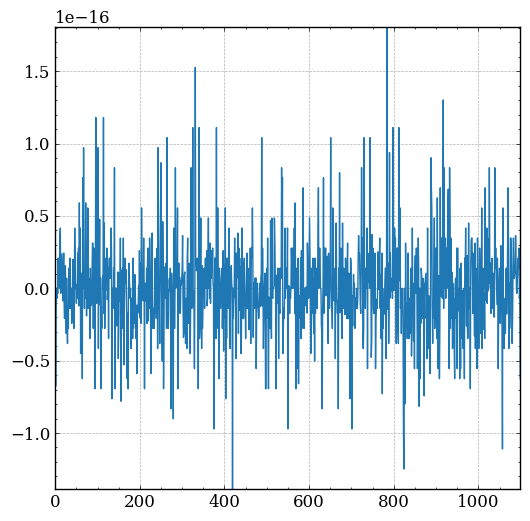

In [11]:
plt.plot((debug[0]['scaler_fold_x'].mean_ - debug1[0]['scaler_fold_x'].mean_))

In [12]:
(debug[i]['X_valid_fold'] - debug1[i]['X_valid_fold'])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
debug[i]['X_valid_fold'].shape

(200, 1100)

In [14]:
debug1[i]['X_valid_fold'].shape

(200, 1100)

In [15]:
np.all(debug[i]['X_valid_fold'] == debug1[i]['X_valid_fold'])

True

In [16]:
np.mean(debug[i]['X_valid_fold'], axis=0) == np.mean(debug1[i]['X_valid_fold'], axis=0)

array([False, False, False, ..., False, False, False])